## 📄 Load and Preview Emotion Labels CSV
Read the audio metadata CSV file and display its structure and a preview of the first few rows.


In [1]:
import pandas as pd

# Load your CSV (adjust the path if needed)
df = pd.read_csv("/kaggle/input/audio-dataset-labels-csv/audio_dataset_labels.csv")

# Show column names
print(df.columns)
df.head()




Index(['filepath', 'label'], dtype='object')


,filepath,label
0,C:\Users\rishi\Downloads\Batch 21 project\Wav2...,neutral
1,C:\Users\rishi\Downloads\Batch 21 project\Wav2...,neutral
2,C:\Users\rishi\Downloads\Batch 21 project\Wav2...,neutral
3,C:\Users\rishi\Downloads\Batch 21 project\Wav2...,neutral
4,C:\Users\rishi\Downloads\Batch 21 project\Wav2...,calm


## 🧹 Clean and Reformat File Paths for Audio Dataset
Convert Windows-style file paths to Kaggle-friendly Unix paths, relabel columns, and save a cleaned version of the dataset.


In [2]:
import pandas as pd
import os

# Load the original CSV
df = pd.read_csv("/kaggle/input/audio-dataset-labels-csv/audio_dataset_labels.csv")

# Extract only the filename from Windows-style paths
df["filename"] = df["filepath"].apply(lambda x: x.replace("\\", "/").split("/")[-1])

# Define your actual audio directory on Kaggle (where you extracted RAVDESS + TESS)
base_audio_path = "/kaggle/working/audio_dataset"

# Rebuild the path to match Kaggle's file system
df["file_path"] = df["filename"].apply(lambda x: os.path.join(base_audio_path, x))

# Optionally rename 'label' to 'emotion' for clarity
df.rename(columns={"label": "emotion"}, inplace=True)

# Drop the old filepath column if desired
df.drop(columns=["filepath", "filename"], inplace=True)

# Save cleaned CSV
df.to_csv("/kaggle/working/cleaned_audio_labels.csv", index=False)

# Preview
df.head()


,emotion,file_path
0,neutral,/kaggle/working/audio_dataset/03-01-01-01-01-0...
1,neutral,/kaggle/working/audio_dataset/03-01-01-01-01-0...
2,neutral,/kaggle/working/audio_dataset/03-01-01-01-02-0...
3,neutral,/kaggle/working/audio_dataset/03-01-01-01-02-0...
4,calm,/kaggle/working/audio_dataset/03-01-02-01-01-0...


## 🧭 Full Preprocessing Pipeline: Load, Label, Resample & Split Audio Dataset
Build a labeled dataset from RAVDESS and TESS, extract emotions, resample audio to 16kHz, and prepare train/test splits for model training.


In [3]:
import os
import pandas as pd
import torchaudio
from datasets import Dataset, Features, Value, Sequence
from sklearn.preprocessing import LabelEncoder

# Step 1: Define dataset paths
tess_path = "/kaggle/input/audio-dataset-zip/dataverse_files"
ravdess_path = "/kaggle/input/audio-dataset-zip/audio datasets"

# Step 2: Emotion mapping for RAVDESS
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

# Step 3: Collect file paths and labels
data = []

# TESS (emotion from folder names)
for emotion_folder in os.listdir(tess_path):
    folder_path = os.path.join(tess_path, emotion_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                data.append({
                    "file_path": os.path.join(folder_path, file),
                    "emotion": emotion_folder.lower()
                })

# RAVDESS (emotion from filename codes)
for root, _, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            if len(parts) > 2:
                emotion_code = parts[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:
                    data.append({
                        "file_path": os.path.join(root, file),
                        "emotion": emotion
                    })

# Step 4: Create DataFrame and encode labels
df = pd.DataFrame(data)
le = LabelEncoder()
df["label"] = le.fit_transform(df["emotion"])

# ✅ Save cleaned label file so it can be reused later
df.to_csv("/kaggle/working/cleaned_audio_labels.csv", index=False)
print("[INFO] Saved cleaned_audio_labels.csv")

# Step 5: Convert to Hugging Face dataset
dataset = Dataset.from_pandas(df[["file_path", "label"]])

# Step 6: Define preprocessing function
def preprocess(example):
    try:
        speech_array, sr = torchaudio.load(example["file_path"])
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            speech_array = resampler(speech_array)

        waveform = speech_array.squeeze().numpy().astype("float32")

        # Ensure it's a proper 1D list
        if waveform.ndim == 1:
            example["input_values"] = waveform.tolist()
        else:
            example["input_values"] = []
    except Exception as e:
        example["input_values"] = []

    return example

# Step 7: Apply with schema
features = Features({
    "file_path": Value("string"),
    "label": Value("int64"),
    "input_values": Sequence(Value("float32")),
})

dataset = dataset.map(preprocess, features=features)

# Step 8: Filter out failed entries
dataset = dataset.filter(lambda x: len(x["input_values"]) > 0)

# Step 9: Train/test split
dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
eval_ds = dataset["test"]

# Step 10: Print stats
print("✅ Preprocessing complete!")
print("Train samples:", len(train_ds))
print("Eval samples:", len(eval_ds))


[INFO] Saved cleaned_audio_labels.csv


Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1440 [00:00<?, ? examples/s]

✅ Preprocessing complete!
Train samples: 1148
Eval samples: 287


## 🧠 Fine-Tune Wav2Vec2 for Emotion Recognition from Speech
Upgrade dependencies, load and preprocess labeled audio, fine-tune a Wav2Vec2 model, evaluate performance, visualize results, and save outputs for inference.


2025-05-23 14:27:48.636996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748010468.846815      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748010468.907306      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[INFO] Data loader initialized...
[INFO] Saved cleaned_audio_labels.csv
[INFO] Mapping dataset...


Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1440 [00:00<?, ? examples/s]

Train samples: 1148
Eval samples: 287


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Training started...


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

[Epoch 2] Loss: 1.8030, Acc: 0.2857, ETA: 01:05:07
[Epoch 3] Loss: 1.4499, Acc: 0.5052, ETA: 00:52:30
[Epoch 4] Loss: 0.7290, Acc: 0.7944, ETA: 00:44:22
[Epoch 5] Loss: 0.6303, Acc: 0.7735, ETA: 00:37:24
[Epoch 6] Loss: 0.5756, Acc: 0.8502, ETA: 00:30:50
[Epoch 7] Loss: 0.6514, Acc: 0.8397, ETA: 00:24:29
[Epoch 8] Loss: 0.5008, Acc: 0.8815, ETA: 00:18:17
[Epoch 9] Loss: 0.4439, Acc: 0.9094, ETA: 00:12:08
[Epoch 10] Loss: 0.3526, Acc: 0.9199, ETA: 00:06:03
[Epoch 11] Loss: 0.3766, Acc: 0.9164, ETA: 00:00:00
[INFO] Training completed.


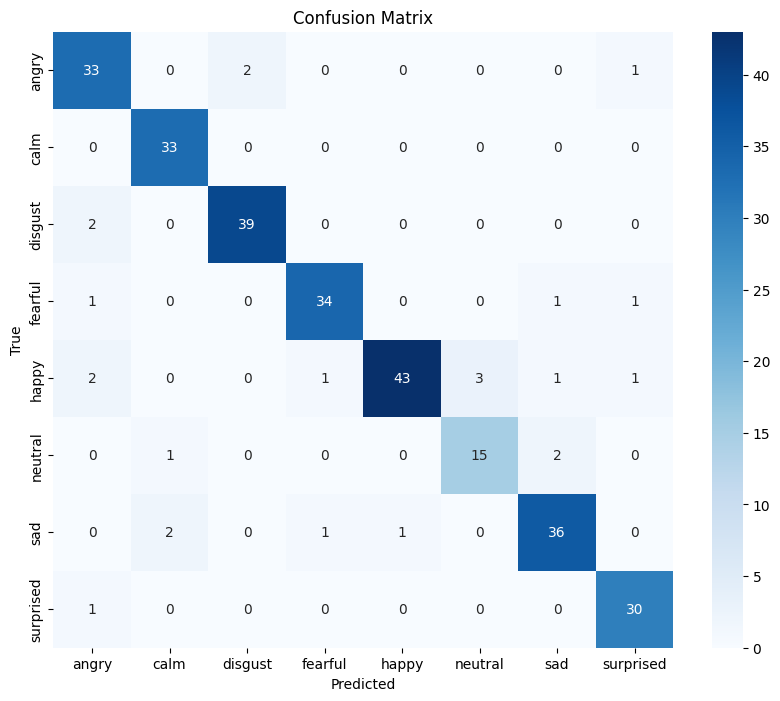

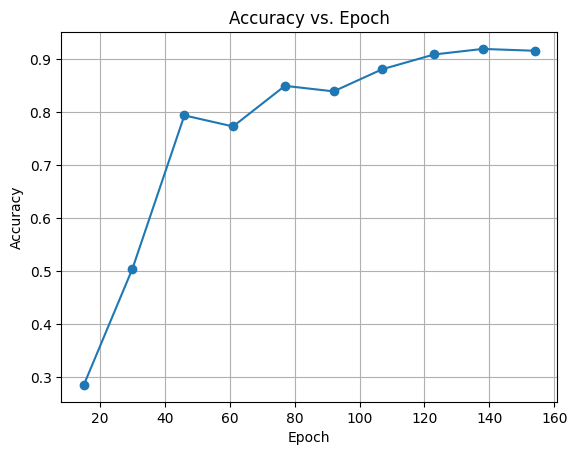


✅ Total Execution Time: 01:00:37


In [4]:
import os
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, Features, Value, Sequence
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments,
    TrainerCallback
)
import warnings
warnings.filterwarnings("ignore")

# === Timer Start ===
start_time = time.time()
print("[INFO] Data loader initialized...")

# === Load and Prepare CSV ===
df = pd.read_csv("/kaggle/working/cleaned_audio_labels.csv")
le = LabelEncoder()
df["label"] = le.fit_transform(df["emotion"])
df.to_csv("/kaggle/working/cleaned_audio_labels.csv", index=False)
print("[INFO] Saved cleaned_audio_labels.csv")

# === Convert to Hugging Face Dataset ===
dataset = Dataset.from_pandas(df[["file_path", "label"]])

# === Preprocessing ===
def preprocess(example):
    try:
        import torchaudio
        speech_array, sr = torchaudio.load(example["file_path"])
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(sr, 16000)
            speech_array = resampler(speech_array)
        waveform = speech_array.squeeze().numpy().astype("float32")
        example["input_values"] = waveform.tolist() if waveform.ndim == 1 else []
    except Exception:
        example["input_values"] = []
    return example

print("[INFO] Mapping dataset...")
features = Features({
    "file_path": Value("string"),
    "label": Value("int64"),
    "input_values": Sequence(Value("float32")),
})
dataset = dataset.map(preprocess, features=features)
dataset = dataset.filter(lambda x: len(x["input_values"]) > 0)
dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
eval_ds = dataset["test"]
print("Train samples:", len(train_ds))
print("Eval samples:", len(eval_ds))

# === Load Model and Processor ===
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(le.classes_),
    label2id={str(i): i for i in range(len(le.classes_))},
    id2label={i: label for i, label in enumerate(le.classes_)}
)

# === Collator ===
def data_collator(features):
    input_values = [f["input_values"] for f in features]
    labels = [f["label"] for f in features]
    inputs = processor(input_values, sampling_rate=16000, padding=True, return_tensors="pt")
    inputs["labels"] = torch.tensor(labels)
    return inputs

# === Metrics ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

# === Logging Callback ===
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            return control
        metrics = self.trainer.evaluate()
        acc = metrics.get("eval_accuracy", 0)
        loss = metrics.get("eval_loss", 0)
        elapsed = time.time() - start_time
        eta = (elapsed / (state.epoch + 1e-9)) * (args.num_train_epochs - state.epoch)
        eta_str = time.strftime("%H:%M:%S", time.gmtime(eta))
        print(f"[Epoch {int(state.epoch)+1}] Loss: {loss:.4f}, Acc: {acc:.4f}, ETA: {eta_str}")
        return control

# === Training Arguments ===
training_args = TrainingArguments(
    output_dir="/kaggle/working/wav2vec2_emotion_model",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    logging_dir="/kaggle/working/logs",
    logging_steps=10,
    run_name="wav2vec2-emotion-run",
    report_to="none"
)

# === Trainer Setup ===
callback = LoggingCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[callback]
)
callback.trainer = trainer

# === Train ===
print("[INFO] Training started...")
trainer.train()
print("[INFO] Training completed.")

# === Save ===
model.save_pretrained("/kaggle/working/wav2vec2_emotion_model")
processor.save_pretrained("/kaggle/working/wav2vec2_emotion_model")

# === Confusion Matrix ===
preds = trainer.predict(eval_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("/kaggle/working/confusion_matrix.png")
plt.show()

# === Accuracy Plot ===
log_history = trainer.state.log_history
epochs = [i+1 for i, entry in enumerate(log_history) if "eval_accuracy" in entry]
accuracies = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]
plt.plot(epochs, accuracies, marker='o')
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("/kaggle/working/accuracy_plot.png")
plt.show()

# === Timer End ===
end_time = time.time()
total_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"\n✅ Total Execution Time: {total_time}")
